# Notebook to compute the state evolution for ridge regression and different resampling

**Pour ridge regression, le lambda optimal est constant a $\sigma^2$**

In [1]:
using RidgeBootstrapStateEvolution
using Plots
using JSON
using Revise

In [2]:
alpha_range = exp10.(range(-1.0, stop=3.0, length=50))
lambda = 1e-3
noise_variance = 1.0

1.0

In [96]:
bootstrap_bootstrap_full_overlaps = []

for alpha in alpha_range
    result = RidgeBootstrapStateEvolution.state_evolution_bootstrap_bootstrap_full(alpha, lambda, noise_variance, max_weight=30, relative_tolerance=1e-20, max_iteration=10000)
    push!(bootstrap_bootstrap_full_overlaps, result)
end

In [100]:
bootstrap_bootstrap_filename::String = "../data/ridge/ridge_bootstrap_bootstrap_overlaps_lambda=$lambda.json"

dict_to_save::Dict = Dict("alpha" => alpha_range,
                          "m"   => [o["m"][1] for o in bootstrap_bootstrap_full_overlaps],
                          "q_diag"   => [o["q"][1, 1] for o in bootstrap_bootstrap_full_overlaps],
                          "q_off_diag"   => [o["q"][1, 2] for o in bootstrap_bootstrap_full_overlaps],
                          "v"   => [o["v"][1] for o in bootstrap_bootstrap_full_overlaps],
                          "mhat"=> [o["mhat"][1] for o in bootstrap_bootstrap_full_overlaps],
                          "qhat_diag"=> [o["qhat"][1, 1] for o in bootstrap_bootstrap_full_overlaps],
                          "qhat_off_diag"=> [o["qhat"][1, 2] for o in bootstrap_bootstrap_full_overlaps],
                          "vhat"=> [o["vhat"][1] for o in bootstrap_bootstrap_full_overlaps],
                          )
open(bootstrap_bootstrap_filename, "w") do f
    write(f, JSON.json(dict_to_save))
end

## 

bootstrap_full_filename::String = "../data/ridge/ridge_bootstrap_full_overlaps_lambda=$lambda.json"

dict_to_save::Dict = Dict("alpha" => alpha_range,
                          "m_full" => [o["m"][3] for o in bootstrap_bootstrap_full_overlaps],
                          "q_bootstrap_full" => [o["q"][1, 3] for o in bootstrap_bootstrap_full_overlaps],
                          "q_full" => [o["q"][3, 3] for o in bootstrap_bootstrap_full_overlaps],
                          "v_full" => [o["v"][3] for o in bootstrap_bootstrap_full_overlaps],
                          "mhat_full" => [o["mhat"][3] for o in bootstrap_bootstrap_full_overlaps],
                          "qhat_bootstrap_full" => [o["qhat"][1, 3] for o in bootstrap_bootstrap_full_overlaps],
                          "qhat_full_full" => [o["qhat"][3, 3] for o in bootstrap_bootstrap_full_overlaps],
                          "vhat_full" => [o["vhat"][3] for o in bootstrap_bootstrap_full_overlaps],
                          )

open(bootstrap_full_filename, "w") do f
    write(f, JSON.json(dict_to_save))
end

8667

---

# Do full-full correlation 

In [101]:
full_full_overlaps = []

for alpha in alpha_range
    result = RidgeBootstrapStateEvolution.state_evolution_full_full(alpha, lambda, noise_variance, relative_tolerance=0.0, max_iteration=30000)
    push!(full_full_overlaps, result)
end 

In [102]:
filename::String = "../data/ridge/ridge_full_full_overlaps_lambda=$lambda.json"

dict_to_save::Dict = Dict("alpha" => alpha_range,
                          "m"   => [o["m"][1] for o in full_full_overlaps],
                          "q_diag"   => [o["q"][1, 1] for o in full_full_overlaps],
                          "q_off_diag"   => [o["q"][1, 2] for o in full_full_overlaps],
                          "v"   => [o["v"][1] for o in full_full_overlaps],
                          "mhat"=> [o["mhat"][1] for o in full_full_overlaps],
                          "qhat_diag"=> [o["qhat"][1, 1] for o in full_full_overlaps],
                          "qhat_off_diag"=> [o["qhat"][1, 2] for o in full_full_overlaps],
                          "vhat"=> [o["vhat"][1] for o in full_full_overlaps],
                          )

open(filename, "w") do f
    write(f, JSON.json(dict_to_save))
end

7899

# y-resampling correlation

In [13]:
y_resampling_overlaps = []

for alpha in alpha_range
    result = RidgeBootstrapStateEvolution.state_evolution_y_resampling(alpha, lambda, noise_variance, relative_tolerance=0.0, max_iteration=20000)
    push!(y_resampling_overlaps, result)
end 

In [14]:
filename::String = "../data/ridge/ridge_y_resampling_overlaps_lambda=$lambda.json"

dict_to_save::Dict = Dict("alpha" => alpha_range,
                          "m"   => [o["m"][1] for o in y_resampling_overlaps],
                          "q_diag"   => [o["q"][1, 1] for o in y_resampling_overlaps],
                          "q_off_diag"   => [o["q"][1, 2] for o in y_resampling_overlaps],
                          "v"   => [o["v"][1] for o in y_resampling_overlaps],
                          "mhat"=> [o["mhat"][1] for o in y_resampling_overlaps],
                          "qhat_diag"=> [o["qhat"][1, 1] for o in y_resampling_overlaps],
                          "qhat_off_diag"=> [o["qhat"][1, 2] for o in y_resampling_overlaps],
                          "vhat"=> [o["vhat"][1] for o in y_resampling_overlaps],
                          )

open(filename, "w") do f
    write(f, JSON.json(dict_to_save))
end

8698

---

# Parametric residual bootstrap

We compute the variance of the residuals, for ridge it's just the training error 

1) On calcule l'overlap de ridge regression 
2) On calcule le bootstrap resampling en utilisant $\rho = q_{\rm erm}$ et $\Delta = \varepsilon_{\rm train}$

In [17]:
function get_train_error(m, q, v, noise_variance; rho = 1.0)
    return (rho + noise_variance + q - 2.0 * m) / (1+v)^2
end

get_train_error (generic function with 1 method)

In [18]:
erm_overlaps = []
parametric_residual_overlaps = []
train_errors = []

for alpha in alpha_range
    result = RidgeBootstrapStateEvolution.state_evolution(alpha, lambda, noise_variance, relative_tolerance=0.0, max_iteration=1000000)
    push!(erm_overlaps, result)
    train_error = get_train_error(result["m"], result["q"], result["v"], noise_variance)
    push!(train_errors, train_error)
    result_2 = RidgeBootstrapStateEvolution.state_evolution_y_resampling(alpha, lambda, train_error, relative_tolerance=1e-10, max_iteration=20000, rho=result["q"])
    push!(parametric_residual_overlaps, result_2)
end

In [19]:
to_save = Dict([
    "alpha" => alpha_range,
    "m" => [o["m"] for o in erm_overlaps],
    "q" => [o["q"] for o in erm_overlaps],
    "v" => [o["v"] for o in erm_overlaps],
    "q_diag_residual" => [o["q"][1, 1] for o in parametric_residual_overlaps],
    "q_off_diag_residual" => [o["q"][1, 2] for o in parametric_residual_overlaps],
    "m_residual" => [o["m"] for o in parametric_residual_overlaps],
])

filename::String = "../data/ridge/ridge_residual_bootstrap_overlaps_lambda=$lambda.json"

open(filename, "w") do f
    write(f, JSON.json(to_save))
end

7879

lambda = 1.0


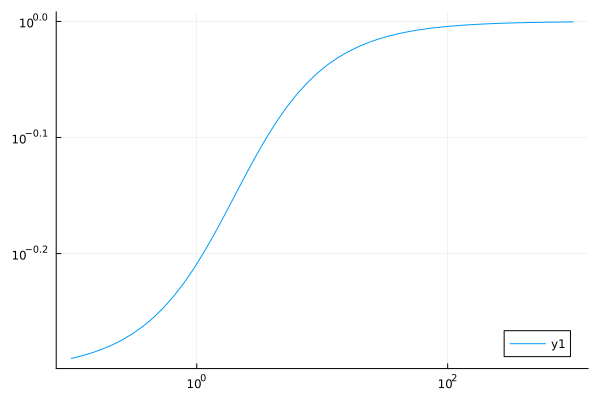

In [20]:
print("lambda = $lambda\n")
plot(alpha_range, train_errors, yaxis=:log, xaxis=:log)

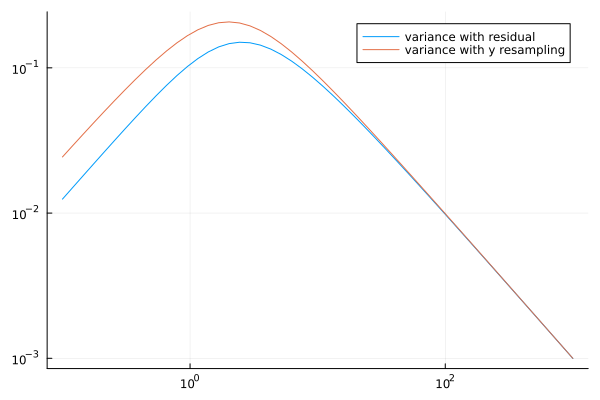

In [21]:
# compare the variance when we do the residual bootstrap vs. resampling the y
# NOTE : quand alpha est très grand, l'erreur va tendre vers 0 donc on a une variance qui tend aussi vers 0 
# d'une autre côté, le resampling de y aura de - en - d'effet car on a bcp de donné donc la variance de 
# l'estimateur

residual_variance   = [o["q"][1, 1] - o["q"][1, 2] for o in parametric_residual_overlaps ]
y_resample_variance = [o["q"][1, 1] - o["q"][1, 2] for o in y_resampling_overlaps ]

plot(alpha_range, residual_variance, yaxis=:log, xaxis=:log, label="variance with residual")
plot!(alpha_range, y_resample_variance, label="variance with y resampling")